# Introduction to Statistical Modeling: Linear Regression and Discrete Regression

**Overview**
- Concept of statistical modeling
- Defining statistical models with Patsy
- Linear regression
- Discrete regression: Logistic regression and Poisson model

We will use the [statsmodels](https://www.statsmodels.org/stable/index.html) libray which provides classes and functions for defining statistical models and fitting them to observed data, for calculating descriptive statistics and carrying out statistical tests. The api modules collect the publically accessible symbols that the library provides.

In [1]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg

/Users/Panu/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The [Patsy](https://patsy.readthedocs.io/en/latest/) library allows us to write statistical models as simple formulas. It is inspired by statiscal software such as R and S.   The statmodels library internally uses the Patsy library and thus we don't need to access the Patsy's functions directly. But we will use Patsy for demonstration.

In [2]:
import patsy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats

**Main Problem:** For a set of response(dependent) variables $Y$, and explanatory(independent) variable $X$, we want to find a relationship (model) between $Y$ and $X$:
- mathematical model:         $~~~ Y = f(X)$
- statistical model:        $~~~ Y = f(X) + \epsilon~~$ where $\epsilon$ is a random variable. A model is statistical when the data ${y_i, x_i}$ has an element of uncertainty (e.g. due to measurement noise) which is described as $\epsilon$.


A widely used model is 
$$
Y = \beta_0 + \beta_1 X + \epsilon,
$$

where $\beta_0$ and $\beta_1$ are model parameters and $\epsilon$ is normally distributed with $0$ mean and variance $\sigma^2$. 
* If $X$ is a scalar, the model is known as *simple linear regression*.
* If $X$ is a vector, the model is known as *multiple linear regression*.
* If $Y$ is a vector, the model is known as *multivariate linear regression*.


After we form the model, we construct the so-called design matrices $y$ and $X$ such that the regression problem can be written on matrix form:

$$
  y = X\beta + \epsilon,
$$

where $y$ is the vector(or matrix) of observations, $\beta$ is a vector of cefficients and $\epsilon$ is the residual(error).

**Example:** Suppose the observed values are $y = [1,2,3,4,5]$ with two independent variables with values $x_1 = [6,7,8,9,10]$ and $x_2 = [11,12,13,14,15]$.  Assume we use the linear model $~ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2$. (Note: *linear* with respect to the coefficents.) Therefore, the design matrix $X$ is $X = [1, x_1, x_2, x_1x_2]$.

In [ ]:
y = np.array([1, 2, 3, 4, 5])
x1 = np.array([6, 7, 8, 9, 10])
x2 = np.array([11, 12, 13, 14, 15])
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T
X

Given $X$ and $y$, we can solve for $\beta$ using least-squares method:

In [ ]:
beta, res, rank, s_val = np.linalg.lstsq(X, y)
print("beta = ", beta)

In this example, constructing the design matrix $X$ is very simple. However, it can be more difficult for more complicated models. The `Patsy` library provides a simple [formula](https://patsy.readthedocs.io/en/latest/formulas.html#the-formula-language) language to handle this.

First, we create a dictionary that maps the variable names to the corresponding data arrays:

In [ ]:
data = {"y": y, "x1": x1, "x2": x2}

To use the model  $~ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2$ with Patsy, we can use the formula `y ~ 1 + x1 + x2 + x1*x2` (leave out the coefficients).  Then we can easily get the design matrices:

In [ ]:
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data)

In [ ]:
y

In [ ]:
X

We can also use the ordinary linear regression (OLS) class in the `statsmodels` library (instead of `np.linalg.lstsq`) to solve for the parameter vector:

In [ ]:
model = sm.OLS(y, X)
result = model.fit()

In [ ]:
result.params

In [ ]:
#compare this with the answer from np.linalg.lstsq
beta

We can skip the step of creating the design matrices by using the statmodels formula API (we imported it as `smf`) by the following:

In [ ]:
#create the dictionary-like object (e.g. a Pandas data frame) that contains the data
df_data = pd.DataFrame(data)
#pass the Patsy formula and the object
model2 = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data)
#find the paramters using fit
result2 = model2.fit()
result2.params

This saves us time when we want to add and remove terms in the model. 

### (Simplified) summary of the Patsy formula syntax

|Syntax|Example| Description |
|:-|:- |:---|
|lhs ~ rhs|y ~ x <br>(equivalent to y ~ 1+x) |~ is used to separate LHS (dependent variables) and <br> RHS (independent variables) | 
|var$*$var| x1$*$x2 <br>(equivalent to x1+x2+x1$*$x2) |An interaction term that implicitly contains all lower-order terms|
|var + var| x1 + x2 <br>(equivalent to y ~ 1+x1+x2) |+ denotes the union of terms |
|var - var| x1 - x2 <br> |- removes the following term |
|var:var| x1:x2 |: denotes a pure interaction term (e.g. $x_1\cdot x_2$)|

For a complete syntax, see the Patsy [documentation](https://patsy.readthedocs.io/en/latest/).

# Linear Regression
**Basic workflow for analyzing a statistic model using statsmodels**:
1. Create an instance of model class, for example, using `model = sm.MODEL(y,X)` or `model = smf.model(formula, data)` where `MODEL` and `model` are the names of a particular model (e.g. OLS, GLS, Logit, etc)
2. Fit the model to the data:  `result = model.fit()`
3. Print summary statistics for the result:  `result.summary()`
4. Post-process the model fit results by methods and attributes `params`, `resid`, `fittedvalues`, `predict`
5. Visualize the result by Matplotlib or `statsmodels.graphics` module.


### Example (linear regression):
Consider fitting a model to generated data whose true value is $ y = 1 + 2x_1 + 3x_2 + 4x_1 x_2$.

In [4]:
N = 100  # number of data points
np.random.seed(123456789)  #so that we get the same numbers (don't need this)
x1 = np.random.randn(N)
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2})
#data

In [5]:
def y_true(x1, x2):
    return 1  + 2 * x1 + 3 * x2 + 4 * x1 * x2

In [6]:
#add "y_true" column to the DataFrame
data["y_true"] = y_true(x1, x2)  
data.head()

,x1,x2,y_true
0,2.212902,-0.474588,-0.198823
1,2.128398,-1.524772,-12.298805
2,1.841711,-1.939271,-15.420705
3,0.082382,0.345148,2.313945
4,0.858964,-0.621523,-1.282107


In [7]:
# Add a normal-distributed noise to the true values and store the result in the y column 
e = 0.5*np.random.randn(N)
data["y"] = data["y_true"] + e 

In [ ]:
data.head()

**1st model: $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$    ** which corresponds to the Patsy formula "`y ~ x1 + x2`".

In [8]:
# Step1: Create an instance of model class (fit the model to the data using ordinary least square)
model = smf.ols("y ~ x1 + x2", data)

In [9]:
# Step2: Fit the model to the data
result = model.fit()

In [10]:
# Step3: Print summary statistics for the result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     31.40
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           3.06e-11
Time:                        14:38:24   Log-Likelihood:                -269.44
No. Observations:                 100   AIC:                             544.9
Df Residuals:                      97   BIC:                             552.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0523      0.375      2.810      0.0

*What to look for:*
- R-squared:  indicates how well the model fits the data. The value is between 0 and 1. The value 1 corresponds to a perfect fit.  (For our example, the R-squared value of 0.393 is pretty poor.)
- The `coef` column contains the model parameters. 
- *t-statistics*:   $t$ = coef/(std err).  If the greater $|t|$, the more likely that the corresponding coefficient is non-zero (which means that it has a significant predictive power). [Recall: the greater $|t|$, the greater the evidence against the null hypothesis. Here the null hypothesis is that the coefficient is $0$.]
- p-value:  small p-value (<0.05) indicates that that coefficient is more likely to be non-zero.  [Recall: small p-value means strong evidence against the null hypothesis.]

Summary:  R-squared close to 1 => good fit. $~~~$High $t$ or small $p$-value => that coef is far from $0$. 

In [11]:
# We can also get the R-squared directly:
result.rsquared

0.39296909795001056

Note that by using ordinary least-square regression we assume that the residuals (of the fitted model and the data) is normally distributed.  Before analyzing data, we might not know if this condition is met. However, we can investigate this by using statistical tests (with null hypothesis that the residuals are normally distributed) and/or plotting the residual.

In [12]:
# we can look at the residual 
result.resid.head()

0    -2.820747
1   -11.080739
2   -12.122715
3    -0.458807
4    -0.551238
dtype: float64

In [13]:
# Check the normality of the residual
z, p = stats.normaltest(result.resid.values)
p

1.5649686805020827e-05

Here $p$-value is very small => reject null hypothesis (i.e. the assummption that the residuals are normally-distributed is violated). (Recall that we're considering our first model ($Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2$)


We can also use a graphical method (`qqplot`) to check for normality. 

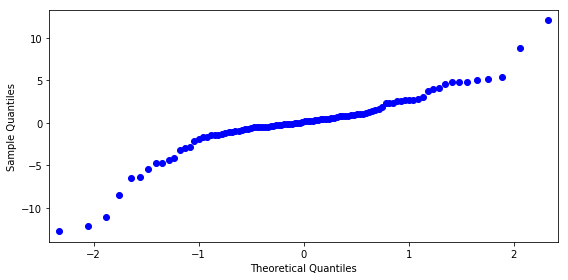

In [14]:
# Use a graphical method to check for normality. (QQ-plot)
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax)
fig.tight_layout()

We can see that the QQ-plot is not quite linear. This suggests that the observed residuals are unlikely to be a sample of a normal-distributed random variable.
Therefore, the first model is not sufficient.  Let's add the interaction term:

**2st model: $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 $   **.  

In [15]:
# Repeat the steps from the previous analysis (Steps 1-3)
del model
model = smf.ols("y ~ x1 + x2 + x1*x2  ", data)
result = model.fit()
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2775.
Date:                Mon, 25 Mar 2019   Prob (F-statistic):           4.25e-93
Time:                        14:44:23   Log-Likelihood:                -70.698
No. Observations:                 100   AIC:                             149.4
Df Residuals:                      96   BIC:                             159.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9353      0.052     18.120      0.0

In [16]:
result.rsquared

0.98859847376633603

The r-squared is very close to 1, indicating a nearly perfect fit.

Then we check if the residuals are normally distributed:

In [17]:
#1. statisical test
z, p = stats.normaltest(result.resid.values)
p
# p is large (>0.05) => weak evidence against the null hypothesis

0.22874710482505045

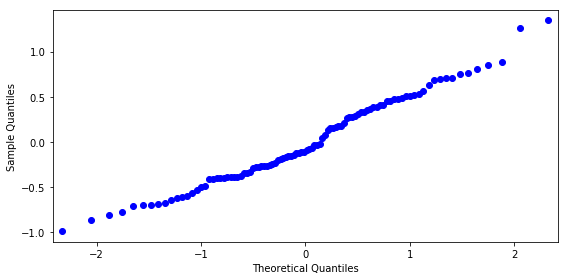

In [18]:
#2. qq-plot 
fig, ax = plt.subplots(figsize=(8, 4))
smg.qqplot(result.resid, ax=ax)

fig.tight_layout()

If we are happy with the fitted model, we can extract the model parameters:

In [19]:
result.params

Intercept    0.935310
x1           1.984672
x2           2.983502
x1:x2        3.971996
dtype: float64

Given values of the indepedent variables ($x_1$, and $x_2$ in this case), we can use the `predict` method to get the prediction (the $y$ value).

In [21]:
x = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x, x)
new_data = pd.DataFrame({"x1": X1.ravel(), "x2": X2.ravel()}) # ravel returns a contiguous flattened array.
y_pred = result.predict(new_data)

In [23]:
new_data.head()

,x1,x2
0,-1.000000,-1.0
1,-0.959184,-1.0
2,-0.918367,-1.0
3,-0.877551,-1.0
4,-0.836735,-1.0


In [24]:
# the result is a vector
y_pred.shape

(2500,)

In [26]:
y_pred

array([[-0.06086817, -0.14198343, -0.22309869, ..., -3.87328548,
        -3.95440074, -4.035516  ],
       [-0.10121487, -0.1757129 , -0.25021092, ..., -3.60262205,
        -3.67712008, -3.7516181 ],
       [-0.14156157, -0.20944236, -0.27732315, ..., -3.33195863,
        -3.39983942, -3.46772021],
       ..., 
       [-1.95716316, -1.72726829, -1.49737343, ...,  8.84789547,
         9.07779033,  9.30768519],
       [-1.99750986, -1.76099776, -1.52448566, ...,  9.11855889,
         9.35507099,  9.59158309],
       [-2.03785656, -1.79472722, -1.55159789, ...,  9.38922231,
         9.63235165,  9.87548099]])

In [25]:
# resize the vector to a square matrix
y_pred = y_pred.reshape(50, 50)

/Users/Panu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [ ]:
# plot the true data and the fitted model
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def plot_y_contour(ax, Y, title):
    c = ax.contourf(X1, X2, Y, 15, cmap=plt.cm.RdBu)
    ax.set_xlabel(r"$x_1$", fontsize=20)
    ax.set_ylabel(r"$x_2$", fontsize=20)
    ax.set_title(title)
    cb = fig.colorbar(c, ax=ax)
    cb.set_label(r"$y$", fontsize=20)

plot_y_contour(axes[0], y_true(X1, X2), "true relation")
plot_y_contour(axes[1], y_pred, "fitted model")

fig.tight_layout()

### Datasets from R
The statmodels provides an interface to load data sets to explore.  See http://www.statsmodels.org/dev/datasets/index.html#available-datasets  for available data sets.

As an example, we will load a dataset named "Icecream" from the package "Ecdat":

In [ ]:
dataset = sm.datasets.get_rdataset("Icecream", "Ecdat")

In [ ]:
dataset.title

In [ ]:
print(dataset.__doc__)

In [ ]:
dataset.data.info()

We see that this dataset has 4 variables: cons(consumption), income, price, and temp. 
Say we want to model the consumption as a linear model with price and temperator as indepdent variables:

In [ ]:
model = smf.ols("cons ~ -1 + price + temp", data=dataset.data)
result = model.fit()
print(result.summary())


In [ ]:
# Graphical tools like plot_fit (regression plot) can give a quick look at our model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

smg.plot_fit(result, 0, ax=ax1)
smg.plot_fit(result, 1, ax=ax2)

fig.tight_layout()

The consumption seems linearly correlated to the temp but doesn't seem so on the price (it's probably because the price range is quite small). 

## References: 
- *Numerical Python: A Practical Techniques Approach for Industry*  by Robert Johansson (Chapter 14)